# Vision Transformer (ViT)

11 classes of white blood cells:
- neutrophils (segmented) - SNE
- eosinophils - EO
- basophils - BA
- lymphocytes - LY
- monocytes - MO
- immature granulocytes (metamyelocytes, myelocytes, promyelocytes) and band - IG or separated - MMY, MY, PMY, BNE
- platelets - PLATELET
- erythroblasts - ERB

inspired by this [notebook](https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning).



The approach is Transfer Learning: we use the Vit_b16 model trained on ImageNet and fine tuned of ImageNet2012. We then proceed to the fine tuning of the last layers of 5 transformers blocks and the head of the model. Attention layer visualisation is used in particular to analyse the model predictions. 


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from PIL.Image import Image

import sys, os
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping
from tensorflow.keras.utils import Sequence

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter
import pickle

from vit_keras import vit, utils
from vit_keras import visualize


sys.path.insert(0, str(Path.cwd().parent.parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

<module 'leukopy_lib' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib.py'>

# Helper functions

In [2]:
def find_layer(model: Model, layer_name: str) -> tuple:
    '''
    find the last choosen layer.
    '''
    for (i, layer) in enumerate(model.layers):
        if layer.name == layer_name:
            return (i, layer)
    
def model_surgery(model: Model) -> Model:
    '''
    Flatten the nested model to a Functional model.
    '''
    submodel_index, submodel = find_layer(model, 'vit-b16')
    x = submodel.outputs[0]
    for layer_index in range(submodel_index+1, len(model.layers)):
        extracted_layer = model.layers[layer_index]
        print('Surgically appending layer : '+str(extracted_layer))
        x = extracted_layer(x)
    new_model = Model(inputs=submodel.inputs, outputs=[x])
    return new_model

In [4]:
def plot_confusion_matrix(df, label_map):
    plt.figure(figsize=(10,8))
    labels = list(label_map.keys())
    g = sns.heatmap(confusion_matrix(df_pred['true_label'], df_pred['pred_label'], 
                                 normalize='true'),
                xticklabels=labels, yticklabels=labels,
                annot=True, cmap='GnBu', square=True, )
    g.set_yticklabels(g.get_yticklabels(), rotation=0) 
    plt.title('confusion matrix')
    plt.ylabel('True labels')
    plt.xlabel('Predicted label')
    plt.show()


In [3]:
def plot_hist(hist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(hist['accuracy'], label='training')
    ax1.plot(hist['val_accuracy'], label='testing')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(hist['loss'], label='training')
    ax2.plot(hist['val_loss'], label='testing')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.close()

    return fig

In [13]:
def get_img_array(img_path: str, dim: tuple) -> np.ndarray:
    img = tf.keras.preprocessing.image.load_img(Path(img_path), target_size = dim)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(img, axis = 0)
    return array, img

def make_gradcam_heatmap(img_array: np.ndarray, model, layer_name: str) -> np.ndarray:
    
    for layer in reversed(model.layers):
        if layer_name in layer.name:
            last_conv_layer = model.get_layer(layer.name)
            break

    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [last_conv_layer.output,  model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output#[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)[1:]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
from datetime import datetime

t = datetime.now().strftime("%d%m%Y_%H")

#saving folder
save = input('To save enter: yes')

if save == 'yes':
    OUTPUT_PATH = Path(f'results/{t}')
    OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

To save enter: yes no


# Set up

## Generate dataframes

In [7]:
INPUT_PATH = Path('../../../data/main_dataset/')

df_train = leuko.generate_images_df(INPUT_PATH/'training_set')
df_test = leuko.generate_images_df(INPUT_PATH/'testing_set')
df_valid = leuko.generate_images_df(INPUT_PATH/'validation_set')

df_train.head()

,img_path,cell_type,label,label_2,label_3
0,../../../data/main_dataset/training_set/PLATEL...,training_set,PLT,PLT,PLT
1,../../../data/main_dataset/training_set/ERB_65...,training_set,ERB,ERB,ERB
2,../../../data/main_dataset/training_set/BA_944...,training_set,BA,BA,BA
3,../../../data/main_dataset/training_set/PLATEL...,training_set,PLT,PLT,PLT
4,../../../data/main_dataset/training_set/MMY_54...,training_set,MMY,IG,IG


## Set constants
For the ViT model the size of the image needs to be a multiple of the patch size. 
Here images are patched into [16x16](https://arxiv.org/abs/2010.11929) images ("images is worth 16x16 words")

In [8]:
BATCH_SIZE = 32
IMG_SIZE  = 352 #need to be a multiple of patch size = 16

EPOCHS = 100
LR = 1e-3

N_CLASSES = 11

## choose classes

In [9]:
N_CLASSES, df_train, df_test, df_valid = leuko.choose_classes(df_train, df_test, df_valid, n_classes = N_CLASSES)

In [10]:
N_CLASSES

11

In [11]:
#sanity check
df_train["label"].value_counts()

EO     2349
PLT    1739
SNE    1263
BNE    1212
ERB    1162
MO     1068
LY      944
BA      903
MY      833
MMY     734
PMY     460
Name: label, dtype: int64

## Image generator
We import images from a dataframe using column names for feature and target. Shuffle is set to false for the testing set.

In [12]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     horizontal_flip = True, 
                                     vertical_flip = True,
                                     shear_range = 0.1)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # uses x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (IMG_SIZE, IMG_SIZE), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # uses y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # uses x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (IMG_SIZE, IMG_SIZE), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # uses y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = BATCH_SIZE, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # uses x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 color_mode = 'rgb',
                                                 classes = None,   # uses y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE, 
                                                 shuffle = False)

# Saving the dictionnary of labels
label_map = training_set.class_indices
print('\n Label map\n ', label_map)

Found 12667 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.

 Label map
  {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


## Model import
We remove the top layer (dense) for fine tuning and adding batch norm to avoid overfitting.

In [330]:
vit_model = vit.vit_b16(
     weights='imagenet21k+imagenet2012',
        image_size = IMG_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False, #fine tune
        classes = N_CLASSES)


In [331]:
vit_model.summary()

Model: "vit-b16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 352, 352, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 22, 22, 768)       590592    
_________________________________________________________________
reshape_2 (Reshape)          (None, 484, 768)          0         
_________________________________________________________________
class_token (ClassToken)     (None, 485, 768)          768       
_________________________________________________________________
Transformer/posembed_input ( (None, 485, 768)          372480    
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 485, 768), (None, 7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 485, 768), (None, 7087

### adding batch normalisation and dense layers to the model

In [332]:
temp_model = tf.keras.Sequential([
    vit_model,
    layers.BatchNormalization(),
    layers.Dense(256, activation = tfa.activations.gelu, name = 'dense_1'),
    layers.BatchNormalization(),
    layers.Dense(11, 'softmax')
    ])

### Flattening the model

In [333]:
model = model_surgery(temp_model)
model.summary()

Surgically appending layer : <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f8805fb1ac0>
Surgically appending layer : <tensorflow.python.keras.layers.core.Dense object at 0x7f881d5e78b0>
Surgically appending layer : <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f880716ba90>
Surgically appending layer : <tensorflow.python.keras.layers.core.Dense object at 0x7f8785e1d340>
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 352, 352, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 22, 22, 768)       590592    
_________________________________________________________________
reshape_2 (Reshape)          (None, 484, 768)          0         
_________________________________________________________________
class_token (

### Setting trainability of layers 

In [335]:
for layer in model.layers[:-11]:
    layer.trainable = False
    
for layer in model.layers:
    print(layer, layer.trainable)
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f88066fb340> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87dde35dc0> False
<tensorflow.python.keras.layers.core.Reshape object at 0x7f880660e0d0> False
<vit_keras.layers.ClassToken object at 0x7f8785f4f460> False
<vit_keras.layers.AddPositionEmbs object at 0x7f88242adc70> False
<vit_keras.layers.TransformerBlock object at 0x7f87de3cd850> False
<vit_keras.layers.TransformerBlock object at 0x7f87de3cda00> False
<vit_keras.layers.TransformerBlock object at 0x7f87de540a00> False
<vit_keras.layers.TransformerBlock object at 0x7f88063663d0> False
<vit_keras.layers.TransformerBlock object at 0x7f87f6f768b0> False
<vit_keras.layers.TransformerBlock object at 0x7f87de5402e0> False
<vit_keras.layers.TransformerBlock object at 0x7f87de540100> False
<vit_keras.layers.TransformerBlock object at 0x7f87dde36640> True
<vit_keras.layers.TransformerBlock object at 0x7f87876d3040> True
<vit_keras.layers.Trans

In [17]:
f1_metric = tfa.metrics.F1Score(num_classes=11, average='macro', name='f1')
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LR)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.05),
              metrics = ['accuracy', f1_metric, precision, recall])

### Adding callbacks

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-7,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 7,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = OUTPUT_PATH/'model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks_list = [earlystopping, reduce_lr, checkpointer]

## Compute weights 
To compensate for the class imbalance

In [20]:
class_weights = leuko.compute_weights(training_set, method = 3)
class_weights

{0: 7.0138427464008855,
 1: 5.225660066006601,
 6: 5.930243445692884,
 7: 7.603241296518607,
 2: 2.696253724989357,
 8: 3.642035652673951,
 10: 5.0146476642913695,
 3: 5.450516351118761,
 4: 6.709216101694915,
 9: 13.768478260869566,
 5: 8.628746594005449}

# Training

In [20]:
epochs = 100
training_history = model.fit(x = training_set, 
                             steps_per_epoch = training_set.n/training_set.batch_size,
                             validation_steps = validation_set.n/validation_set.batch_size,

                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set, 
                             class_weight = class_weights
                            )

model.save(path)

Epoch 1/100
395/395 [==============================] - 679s 2s/step - loss: 11.4248 - accuracy: 0.4025 - f1: 0.3512 - precision: 0.5866 - recall: 0.2892 - val_loss: 1.0318 - val_accuracy: 0.7289 - val_f1: 0.6189 - val_precision: 0.8316 - val_recall: 0.6595

Epoch 00001: val_accuracy improved from -inf to 0.72890, saving model to ../working/model_save/vit_b16/31102021_10/model.hdf5
Epoch 2/100
395/395 [==============================] - 602s 2s/step - loss: 5.5289 - accuracy: 0.7587 - f1: 0.6997 - precision: 0.8459 - recall: 0.6724 - val_loss: 0.8943 - val_accuracy: 0.7514 - val_f1: 0.6763 - val_precision: 0.8081 - val_recall: 0.7035

Epoch 00002: val_accuracy improved from 0.72890 to 0.75145, saving model to ../working/model_save/vit_b16/31102021_10/model.hdf5
Epoch 3/100
395/395 [==============================] - 596s 2s/step - loss: 4.8892 - accuracy: 0.7889 - f1: 0.7385 - precision: 0.8584 - recall: 0.7050 - val_loss: 1.0103 - val_accuracy: 0.7121 - val_f1: 0.6624 - val_precision: 0.

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


# Saving
## History

In [23]:
with open(OUTPUT_PATH/'training_hist_b16', 'wb') as f:
    pickle.dump(training_history.history, f)

## Testing pred and eval

In [24]:
model.evaluate(testing_set)


80/80 [==============================] - 50s 626ms/step - loss: 0.5426 - accuracy: 0.8919 - f1: 0.8625 - precision: 0.9136 - recall: 0.8687


[0.5426194667816162,
 0.891902506351471,
 0.8624870777130127,
 0.9136006832122803,
 0.8687106966972351]

In [27]:
#make predictions on the test set
predictions = model.predict(testing_set)
y_pred = tf.argmax(predictions, axis = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


In [ ]:
#create df
test_label_map = {v:k for k, v in testing_set.class_indices.items()}
df_pred = pd.DataFrame({'true':testing_set.classes,
                        'true_label':df_test['label'],
                        'pred':y_pred,
                        'img_path':df_test['img_path']})
df_pred['pred_label'] = df_pred['pred'].map(test_label_map)
df_pred.to_pickle(OUTPUT_PATH/'pred_b16.pk')

# Evaluation

In [13]:
#history load and pred
with open('results/training_hist_b16', 'rb') as f:
    hist = pickle.load(f) 
    
df_pred = pd.read_pickle('results/pred_b16.pk')
df_pred.img_path = df_pred.img_path.str.replace('../input/main-dataset/', '../../../data/') # local path

<ipython-input-13-45d326cd640e>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pred.img_path = df_pred.img_path.str.replace('../input/main-dataset/', '../../../data/') # local path


## Training history

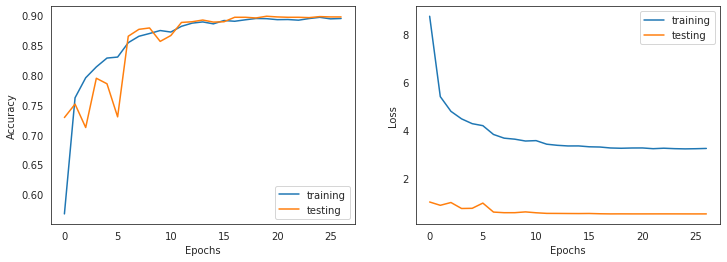

In [14]:
sns.set_style('white')
plot_hist(hist)

## Confusion matrix

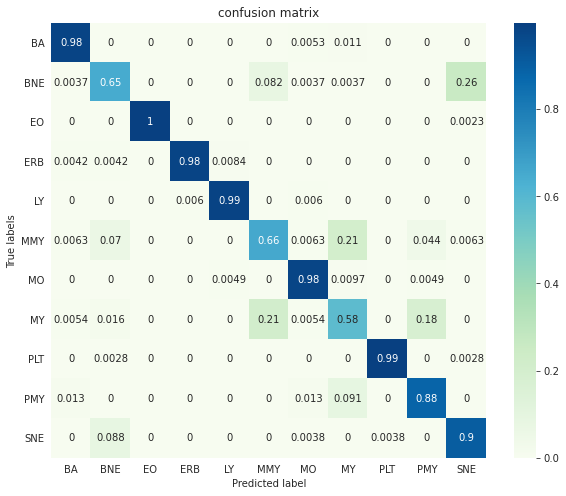

In [17]:
plot_confusion_matrix(df_pred, label_map)

## Classification report

In [341]:
pd.DataFrame.from_dict(classification_report(df_pred['true'], 
                                             df_pred['pred'], 
                                             target_names=label_map,
                                             output_dict=True)).transpose()

,precision,recall,f1-score,support
BA,0.973822,0.984127,0.978947,189.000000
BNE,0.816901,0.649254,0.723493,268.000000
EO,1.000000,0.997685,0.998841,432.000000
ERB,0.995726,0.983122,0.989384,237.000000
LY,0.982249,0.988095,0.985163,168.000000
MMY,0.630303,0.658228,0.643963,158.000000
MO,0.966507,0.980583,0.973494,206.000000
MY,0.703947,0.581522,0.636905,184.000000
PLT,0.997238,0.994490,0.995862,363.000000
PMY,0.623853,0.883117,0.731183,77.000000


## Visualise images and attention

### load model

In [17]:
%%capture --no-display
trained_model = keras.models.load_model('results')

### Visualise patches

In [144]:
def plot_patches(patch_size: int, img_path: Path = df_test.img_path[0]):
    arr, img = leuko.get_img_array(img_path, (IMG_SIZE, IMG_SIZE))
    patches = tf.image.extract_patches(images=arr, 
                                       sizes=[1, patch_size, patch_size, 1], 
                                       strides=[1, patch_size, patch_size, 1], 
                                       rates=[1, 1, 1, 1], 
                                       padding='VALID')
    
    patches = tf.reshape(patches,[-1,patch_size,patch_size,3])
    n = int(np.sqrt(patches.shape[0]))

    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches):
        ax = plt.subplot(n, n, i + 1)
        plt.imshow(patch)
        plt.axis('off')

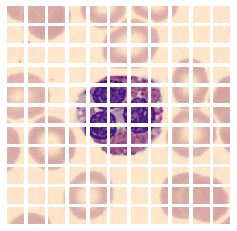

In [145]:
plot_patches(32)

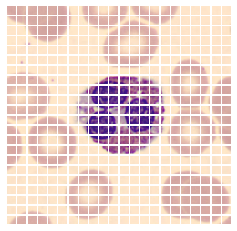

In [146]:
plot_patches(16)

### Visualise attention map

In [31]:
def plot_attention_vs_gradcam(model: Model, img_path: str, img_size: int = IMG_SIZE):
    arr, img = get_img_array(img_path, (img_size, img_size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    gradcam_img = gradcam(model, img, 'encoder_norm')
    attention_map = visualize.attention_map(model, img)

    # Plot images
    fig, (ax1, ax2) = plt.subplots(ncols = 2)
    ax1.axis('off')
    ax1.set_title('GradCam')
    ax1.imshow(gradcam_img)
    
    ax2.axis('off')
    ax2.set_title('Attention Map')
    ax2.imshow(attention_map)
    
    return fig

In [32]:
def gradcam(model: Model, img: np.ndarray, layer_name: str) -> Image:

    heatmap = make_gradcam_heatmap(arr, model, layer_name)
    heatmap = np.uint8(255 * heatmap)
    
    size_embedding = model.layers[1].output_shape[1]
    heatmap = np.reshape(heatmap, (size_embedding,size_embedding))
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[..., :-1]
    jet_heatmap = jet_colors[heatmap]


    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

/home/marie-anne/anaconda3/envs/DStest/lib/python3.9/site-packages/tensorflow_addons/activations/gelu.py:79: UserWarning: Default value of `approximate` is changed from `True` to `False`
  warnings.warn(


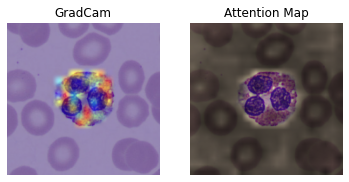

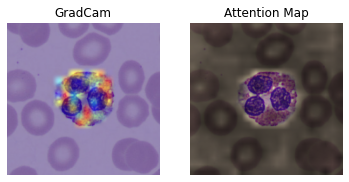

In [33]:
plot_attention_vs_gradcam(trained_model, df_test.img_path[0])

In [22]:
arr, img = get_img_array(df_test.img_path[0], (IMG_SIZE, IMG_SIZE))
img = tf.keras.preprocessing.image.img_to_array(img)

In [ ]:
x[0][5].shape

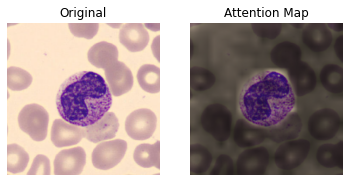

In [23]:
x = testing_set.next()
image = x[0][5]

plot_attention(img, trained_model);

In [19]:
type(gradcam(df_test.img_path[0], IMG_SIZE, trained_model, 'encoder_norm'))

/home/marie-anne/anaconda3/envs/DStest/lib/python3.9/site-packages/tensorflow_addons/activations/gelu.py:79: UserWarning: Default value of `approximate` is changed from `True` to `False`
  warnings.warn(


PIL.Image.Image

# Model selection analyses 

In [19]:
res_metrics = pd.read_excel('results/results_training.xlsx')
res_classes = pd.read_excel('results/results_training.xlsx', sheet_name=1, header=[0, 1], index_col=0) \
.transpose() \
.reset_index(level=1) \
.rename(columns={'level_1':'metrics'})

In [20]:
def plot_metrics_training(df, name, ax=None):
    if ax is None:
        ax = plt.gca()
        
    sns.set_style('whitegrid')
    
    temp_df =  df.set_index('Number of trained transformers')[[f'{name}', f'val_{name}', f'test_{name}']]
     
    temp_df.plot(ax=ax, 
                 style='.--',
                 alpha=0.7,
                )
    
    ax.set_ylabel(f'{name}')
    ax.set_title(name)


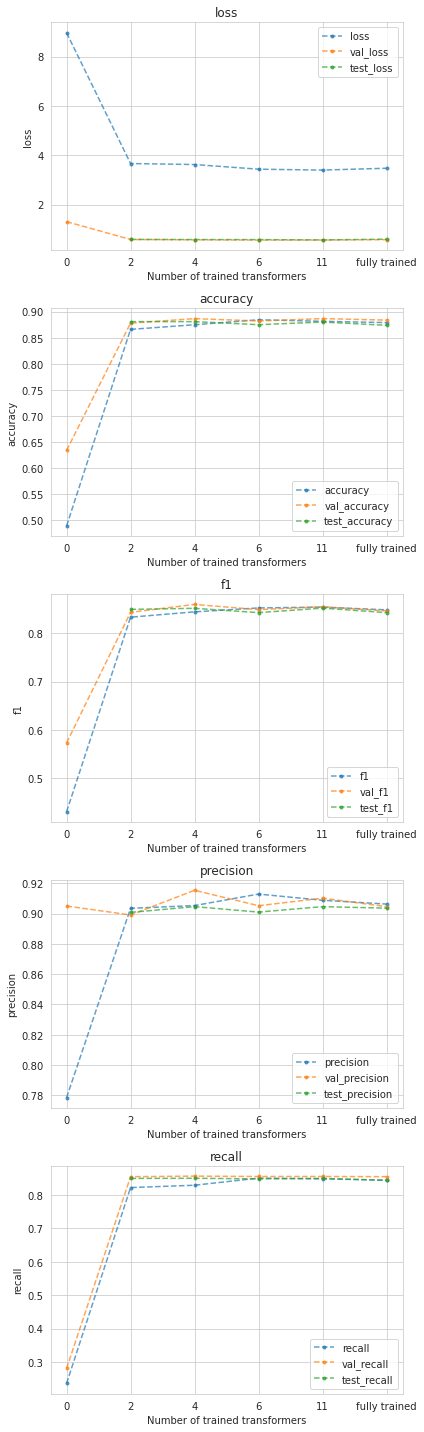

In [312]:
fig, axes = plt.subplots(5, 1, figsize=(6, 20))

for metrics, ax in zip(['loss', 'accuracy', 'f1', 'precision', 'recall'], axes.flatten()):
    plot_metrics_training(res_metrics, metrics, ax=ax)
    


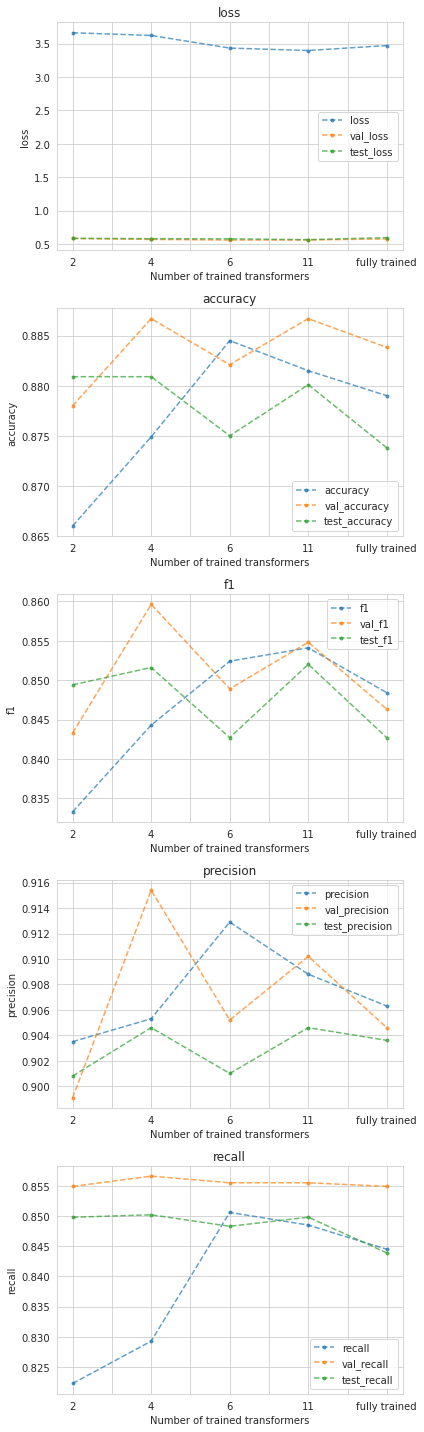

In [313]:
fig, axes = plt.subplots(5, 1, figsize=(6, 20))

for metrics, ax in zip(['loss', 'accuracy', 'f1', 'precision', 'recall'], axes.flatten()):
    plot_metrics_training(res_metrics.iloc[1:], metrics, ax=ax)
plt.tight_layout()

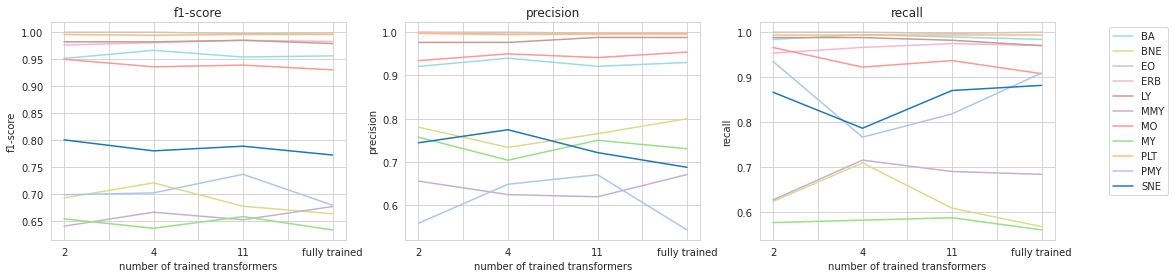

In [39]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for metrics, ax in zip(['f1-score', 'precision', 'recall'], axes.flatten()):
    res_classes[res_classes.metrics == metrics].plot(ax=ax, title=metrics, legend=False, ylabel=metrics, xlabel ='number of trained transformers', 
                                                     cmap='tab20_r')
plt.legend(bbox_to_anchor=(1.4,1))